# Message Classifier, Multi class with a Neural Network

Gilbert François Duivesteijn (gilbert@deep-impact.ch)



<img src="https://github.com/learning-stack/Colab-ML-Playbook/blob/master/NLP/Automatic%20tagging%20of%20short%20texts/images/dt140704.gif?raw=1" width=800>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import itertools

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

np.set_printoptions(precision=3, linewidth=100)

Using TensorFlow backend.


In [2]:
# Import custom library from my github

import urllib.request

def download(url):
    filename = url.split('/')[-1]
    print ('Downloading', filename)
    f =  urllib.request.urlopen(url)
    data = f.read()
    f.close()
    with open(filename, 'wb') as myfile:
        myfile.write(data)

# get .py file from repository
download('https://raw.githubusercontent.com/learning-stack/Colab-ML-Playbook/master/NLP/Automatic%20tagging%20of%20short%20texts/lib/utils.py')

from utils import plot_confusion_matrix

In [0]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [4]:
!wget https://github.com/gilbertfrancois/pydata2018-tagging/blob/master/data/messages-cls.pkl?raw=true

--2019-01-05 02:08:05--  https://github.com/gilbertfrancois/pydata2018-tagging/blob/master/data/messages-cls.pkl?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gilbertfrancois/pydata2018-tagging/raw/master/data/messages-cls.pkl [following]
--2019-01-05 02:08:05--  https://github.com/gilbertfrancois/pydata2018-tagging/raw/master/data/messages-cls.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gilbertfrancois/pydata2018-tagging/master/data/messages-cls.pkl [following]
--2019-01-05 02:08:05--  https://raw.githubusercontent.com/gilbertfrancois/pydata2018-tagging/master/data/messages-cls.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecti

In [0]:
df_cls_messages = pd.read_pickle('messages-cls.pkl?raw=true')

In [0]:
dict_classes = {
    0: 'late/early',
    1: 'holidays',
    2: 'home office',
    3: 'med app',
    4: 'ill',
    5: 'business',
    6: 'in office',
    7: 'miscellaneous'
}

In [7]:
samples = df_cls_messages.dropna()
samples['class'] = samples.loc[:, 'class'].astype(np.uint8).values

samples['text'] = samples['text'].str.lower()
samples['text'] = samples['text'].str.replace('ho','home office')
samples['text'] = samples['text'].str.replace('homeoffice','home office')

len(samples)

1719

In [8]:
X = samples['text']
y = samples['class']

X[:10]

0    i have to pick up my car from the garage tomor...
1           i won’t be here tomorrow, one day vacation
2    missed connection in zurich. will be about 5-1...
3                                               enjoy!
4           i am away for 2 weeks in iceland :flag-is:
5    monday is the first day in schome officeol for...
6    going to leave around 4:50 because i need to g...
7    i am away between 3-4 for private stuff, be ba...
8    i will move to home office. i will be in 2 dif...
9    need to leave around 16:45. will be available ...
Name: text, dtype: object

In [0]:
# Embedding
max_features = 3000
maxlen = 50
embedding_size = 100

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 20
epochs = 12

## Tokenizing

In [10]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(X)
Xt = tokenizer.texts_to_sequences(X)

print(X.iloc[2])
print(Xt[2])

missed connection in zurich. will be about 5-10 mins late in the office, so will miss the weekly today.
[121, 330, 6, 115, 5, 4, 70, 219, 66, 402, 32, 6, 2, 7, 42, 5, 360, 2, 459, 12]


In [11]:
word_index = tokenizer.word_index
num_words = len(word_index)
print('Number of words in the corpus: {}'.format(num_words))

Number of words in the corpus: 2476


In [12]:
len_list = np.array([len(x) for x in Xt])
mean_len = np.mean(len_list)
std_len = np.std(len_list)
print(mean_len, std_len)

16.07737056428156 10.641186564106366


## Multi Label Binarizer

In [13]:
yc = to_categorical(y-1)
yc[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Sequence padding

Make all input vectors the same size by truncating or adding zeros.

In [14]:
Xts = sequence.pad_sequences(Xt, maxlen=maxlen, padding='post')
print(X[0], '\n')
print(Xt[0], '\n')
print(Xts[0], '\n')

i have to pick up my car from the garage tomorrow. i have to leave at 15:45 on thursday. 

[1, 16, 3, 202, 114, 17, 183, 20, 2, 243, 13, 1, 16, 3, 21, 10, 47, 94, 14, 48] 

[  1  16   3 202 114  17 183  20   2 243  13   1  16   3  21  10  47  94  14  48   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] 



## Split dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Xts, yc, test_size=0.10, random_state=1)

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape : {}'.format(X_test.shape))

X_train shape: (1547, 50)
X_test shape : (172, 50)


## Build and train the model

In [0]:
def build_and_train_model(X_train, X_test, y_train, y_test, verbose=1):
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(8))
    model.add(Activation('softmax'))

    callback = EarlyStopping(monitor='val_acc', patience=2)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Train...')
    H = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test), callbacks=[callback], verbose=verbose)
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    print('Test accuracy:', acc)
    return model, H, acc

In [17]:
model, H, acc = build_and_train_model(X_train, X_test, y_train, y_test)

Build model...
Train...
Train on 1547 samples, validate on 172 samples
Epoch 1/12
1547/1547 [==============================] - 4s 2ms/step - loss: 1.8540 - acc: 0.2973 - val_loss: 1.7529 - val_acc: 0.3023
Epoch 2/12
1547/1547 [==============================] - 2s 1ms/step - loss: 1.4270 - acc: 0.5165 - val_loss: 1.0841 - val_acc: 0.6686
Epoch 3/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.8716 - acc: 0.7207 - val_loss: 0.9444 - val_acc: 0.6860
Epoch 4/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.6056 - acc: 0.8145 - val_loss: 0.9472 - val_acc: 0.7035
Epoch 5/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.4826 - acc: 0.8494 - val_loss: 0.9337 - val_acc: 0.6977
Epoch 6/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.3489 - acc: 0.8953 - val_loss: 0.9053 - val_acc: 0.7733
Epoch 7/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.2841 - acc: 0.9218 - val_loss: 0.8131 - val_acc

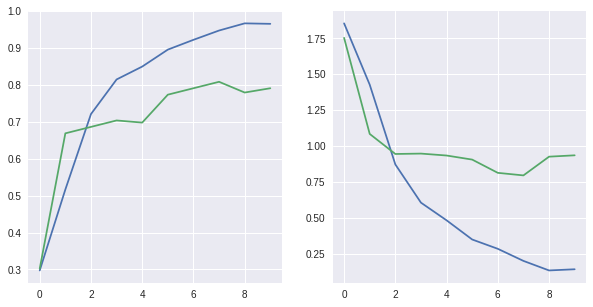

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(H.history['acc'], label='acc')
axs[0].plot(H.history['val_acc'], label='val_acc')
axs[1].plot(H.history['loss'], label='loss')
axs[1].plot(H.history['val_loss'], label='val_loss')

In [0]:
y_pred = model.predict(X_test)

In [20]:
print(classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1)))
cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);

              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.92      0.75      0.83        16
           2       0.86      0.92      0.89        48
           3       0.83      0.38      0.53        13
           4       0.62      1.00      0.77         5
           5       0.80      0.62      0.70        13
           6       0.12      0.25      0.17         4
           7       0.89      0.70      0.78        23

   micro avg       0.79      0.79      0.79       172
   macro avg       0.73      0.69      0.69       172
weighted avg       0.82      0.79      0.79       172



<IPython.core.display.Javascript object>

Normalized confusion matrix


## Training an ensemble

Since we do early stopping, to minimise overfitting, the model is not fully trained yet. The effect of random initialisation is noticable. Hence, when training e.g. 10 times from scratch, you end up with 10 models with different performance. An idea to smooth this effect is to train multiple times and use all models for the prediction. Add all resulting output vectors and take the $argmax$. This will be your final prediction.

In [21]:
n_models = 10

model_list = []
H_list = []
acc_list = []
for i in range(n_models):
    print('Training model {}'.format(i+1))
    _model, _H, _acc = build_and_train_model(X_train, X_test, y_train, y_test, verbose=0)
    model_list.append(_model)
    H_list.append(_H)
    acc_list.append(_acc)

Training model 1
Build model...
Train...
172/172 [==============================] - 0s 289us/step
Test accuracy: 0.7674418618512708
Training model 2
Build model...
Train...
172/172 [==============================] - 0s 291us/step
Test accuracy: 0.7790697674418605
Training model 3
Build model...
Train...
172/172 [==============================] - 0s 285us/step
Test accuracy: 0.7790697716003241
Training model 4
Build model...
Train...
172/172 [==============================] - 0s 305us/step
Test accuracy: 0.7151162832282311
Training model 5
Build model...
Train...
172/172 [==============================] - 0s 296us/step
Test accuracy: 0.7093023269675499
Training model 6
Build model...
Train...
172/172 [==============================] - 0s 306us/step
Test accuracy: 0.7558139548745266
Training model 7
Build model...
Train...
172/172 [==============================] - 0s 316us/step
Test accuracy: 0.7848837264748507
Training model 8
Build model...
Train...
172/172 [==========================

In [29]:
print('Mean test accuracy: {:.3f}'.format(np.mean(np.array(acc_list))))

Mean test accuracy: 0.759


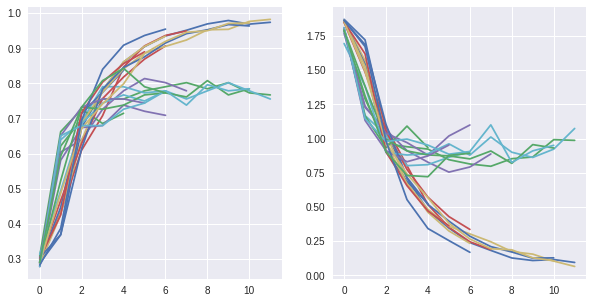

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for H in H_list:
    axs[0].plot(H.history['acc'], label='acc')
    axs[0].plot(H.history['val_acc'], label='val_acc')
    axs[1].plot(H.history['loss'], label='loss')
    axs[1].plot(H.history['val_loss'], label='val_loss')

In [0]:
y_pred_list = []
for index in range(len(X_test)):
    y_pred = np.zeros(8)
    for model in model_list:
        y_pred += model.predict(X_test[index][np.newaxis])[0]
    y_pred_list.append(y_pred)
    
y_pred = np.array(y_pred_list)

In [32]:
accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

0.8197674418604651

              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.81      0.81      0.81        16
           2       0.91      0.90      0.91        48
           3       0.90      0.69      0.78        13
           4       1.00      1.00      1.00         5
           5       0.55      0.92      0.69        13
           6       0.00      0.00      0.00         4
           7       0.89      0.70      0.78        23

   micro avg       0.82      0.82      0.82       172
   macro avg       0.73      0.73      0.73       172
weighted avg       0.82      0.82      0.82       172

Accuracy: 0.820
Normalized confusion matrix


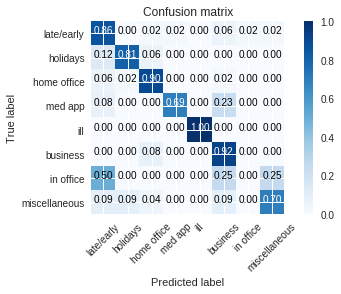

In [33]:
print(classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1)))
print('Accuracy: {:.3f}'.format(accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))))
cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);

In [0]:
def tag_message(message):
    X_new = tokenizer.texts_to_sequences([message])
    x1_new = sequence.pad_sequences(X_new, maxlen=maxlen, padding='post')
    y_pred_list = []
    for model in model_list:
        y_pred_list.append(model.predict(x1_new))
    y_pred = np.argmax(np.sum(np.array(y_pred_list), axis=0) / 10.0)
    print('{:>20} | {}'.format(dict_classes[y_pred], message))

In [35]:
tag_message('My alarm clock was not set properly. I come to the office asap.')
tag_message('It is my scheduled day off.')
tag_message('See you on Wednesday.')
tag_message('Not feeling well today, I had to vomit.')
tag_message('I work at home on Tuesday.')
tag_message('This morning I have a meeting at ACME.')
tag_message('The roads are super slippery, will miss the daily')
tag_message('get well soon!')
tag_message('I\'m away for a long lunch between 12:00 and 15:30')
tag_message('I have an appointment at the physio.')

          late/early | My alarm clock was not set properly. I come to the office asap.
            holidays | It is my scheduled day off.
            holidays | See you on Wednesday.
                 ill | Not feeling well today, I had to vomit.
            business | I work at home on Tuesday.
            business | This morning I have a meeting at ACME.
          late/early | The roads are super slippery, will miss the daily
       miscellaneous | get well soon!
          late/early | I'm away for a long lunch between 12:00 and 15:30
             med app | I have an appointment at the physio.


## Transfer learning with pretrained embeddings

In [37]:
# Download and unzip the word embedding file

!wget http://nlp.stanford.edu/data/glove.6B.zip
  
!unzip glove*.zip

--2019-01-05 02:28:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-01-05 02:28:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  42.4MB/s    in 20s     

2019-01-05 02:29:08 (40.3 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [38]:
embeddings_index = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embeddings_index['home'].shape

(100,)

In [40]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(2477, 100)


In [41]:
print('Build model...')

model = Sequential()
# model.add(Input(shape=(maxlen,), dtype='int32'))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(8))
model.add(Activation('softmax'))

callback = EarlyStopping(monitor='val_acc', patience=1)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
H = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test), callbacks=[callback])
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Train on 1547 samples, validate on 172 samples
Epoch 1/12
1547/1547 [==============================] - 5s 3ms/step - loss: 1.8297 - acc: 0.3012 - val_loss: 1.6873 - val_acc: 0.3953
Epoch 2/12
1547/1547 [==============================] - 2s 1ms/step - loss: 1.5269 - acc: 0.4615 - val_loss: 1.3202 - val_acc: 0.5698
Epoch 3/12
1547/1547 [==============================] - 2s 1ms/step - loss: 1.1421 - acc: 0.6361 - val_loss: 1.0312 - val_acc: 0.6744
Epoch 4/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.8624 - acc: 0.7149 - val_loss: 0.8160 - val_acc: 0.7500
Epoch 5/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.7584 - acc: 0.7615 - val_loss: 0.8049 - val_acc: 0.7558
Epoch 6/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.6324 - acc: 0.8022 - val_loss: 0.7705 - val_acc: 0.7674
Epoch 7/12
1547/1547 [==============================] - 2s 1ms/step - loss: 0.5741 - acc: 0.8281 - val_loss: 0.7137 - val_acc

In [0]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.80      0.75      0.77        16
           2       0.93      0.81      0.87        48
           3       0.90      0.69      0.78        13
           4       0.45      1.00      0.62         5
           5       0.55      0.85      0.67        13
           6       0.00      0.00      0.00         4
           7       0.86      0.78      0.82        23

   micro avg       0.81      0.81      0.81       172
   macro avg       0.67      0.72      0.68       172
weighted avg       0.82      0.81      0.81       172

Normalized confusion matrix


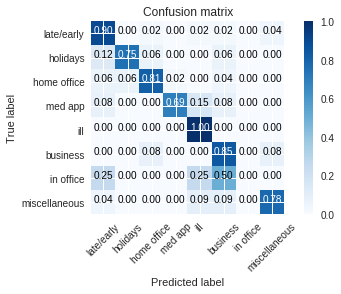

In [43]:
print(classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1)))
cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=np.argmax(y_test, axis=1))
plt.figure()
plot_confusion_matrix(cm, classes=dict_classes.values(), normalize=True);